In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt

In [2]:
f = open('./dataset_OSAS.pickle', 'rb')
data = pickle.load(f)
f.close()

## The loaded data variable is a pandas dataframe with the following columns:
## ['patient', 'timestamp_datetime', 'HR(bpm)', 'SpO2(%)', 'PI(%)',
##   'RR(rpm)', 'PVCs(/min)', 'event', 'anomaly', 'signal_pleth',
##   'signal_ecg_i', 'signal_ecg_ii', 'signal_ecg_iii', 'PSG_Abdomen',
##   'PSG_Flow', 'PSG_Position', 'PSG_Snore', 'PSG_Thorax']
### patient - id of the patient for a given row
### timestamp_datetime - timestamp of the row data
### HR(bpm) - heart rate in beats per minute of the patient
### Sp02(%) -  Oxygen Saturation Measurement
### PI(%) - Perfusion index. ratio of pulsing blood to non-pulsing blood. .2% (weak pulse) 20% (very strong)
### RR(rpm) - respiratory rate per minute
### PVCs(/min) - premature ventricular contraction 
### event
### anomaly
### ...

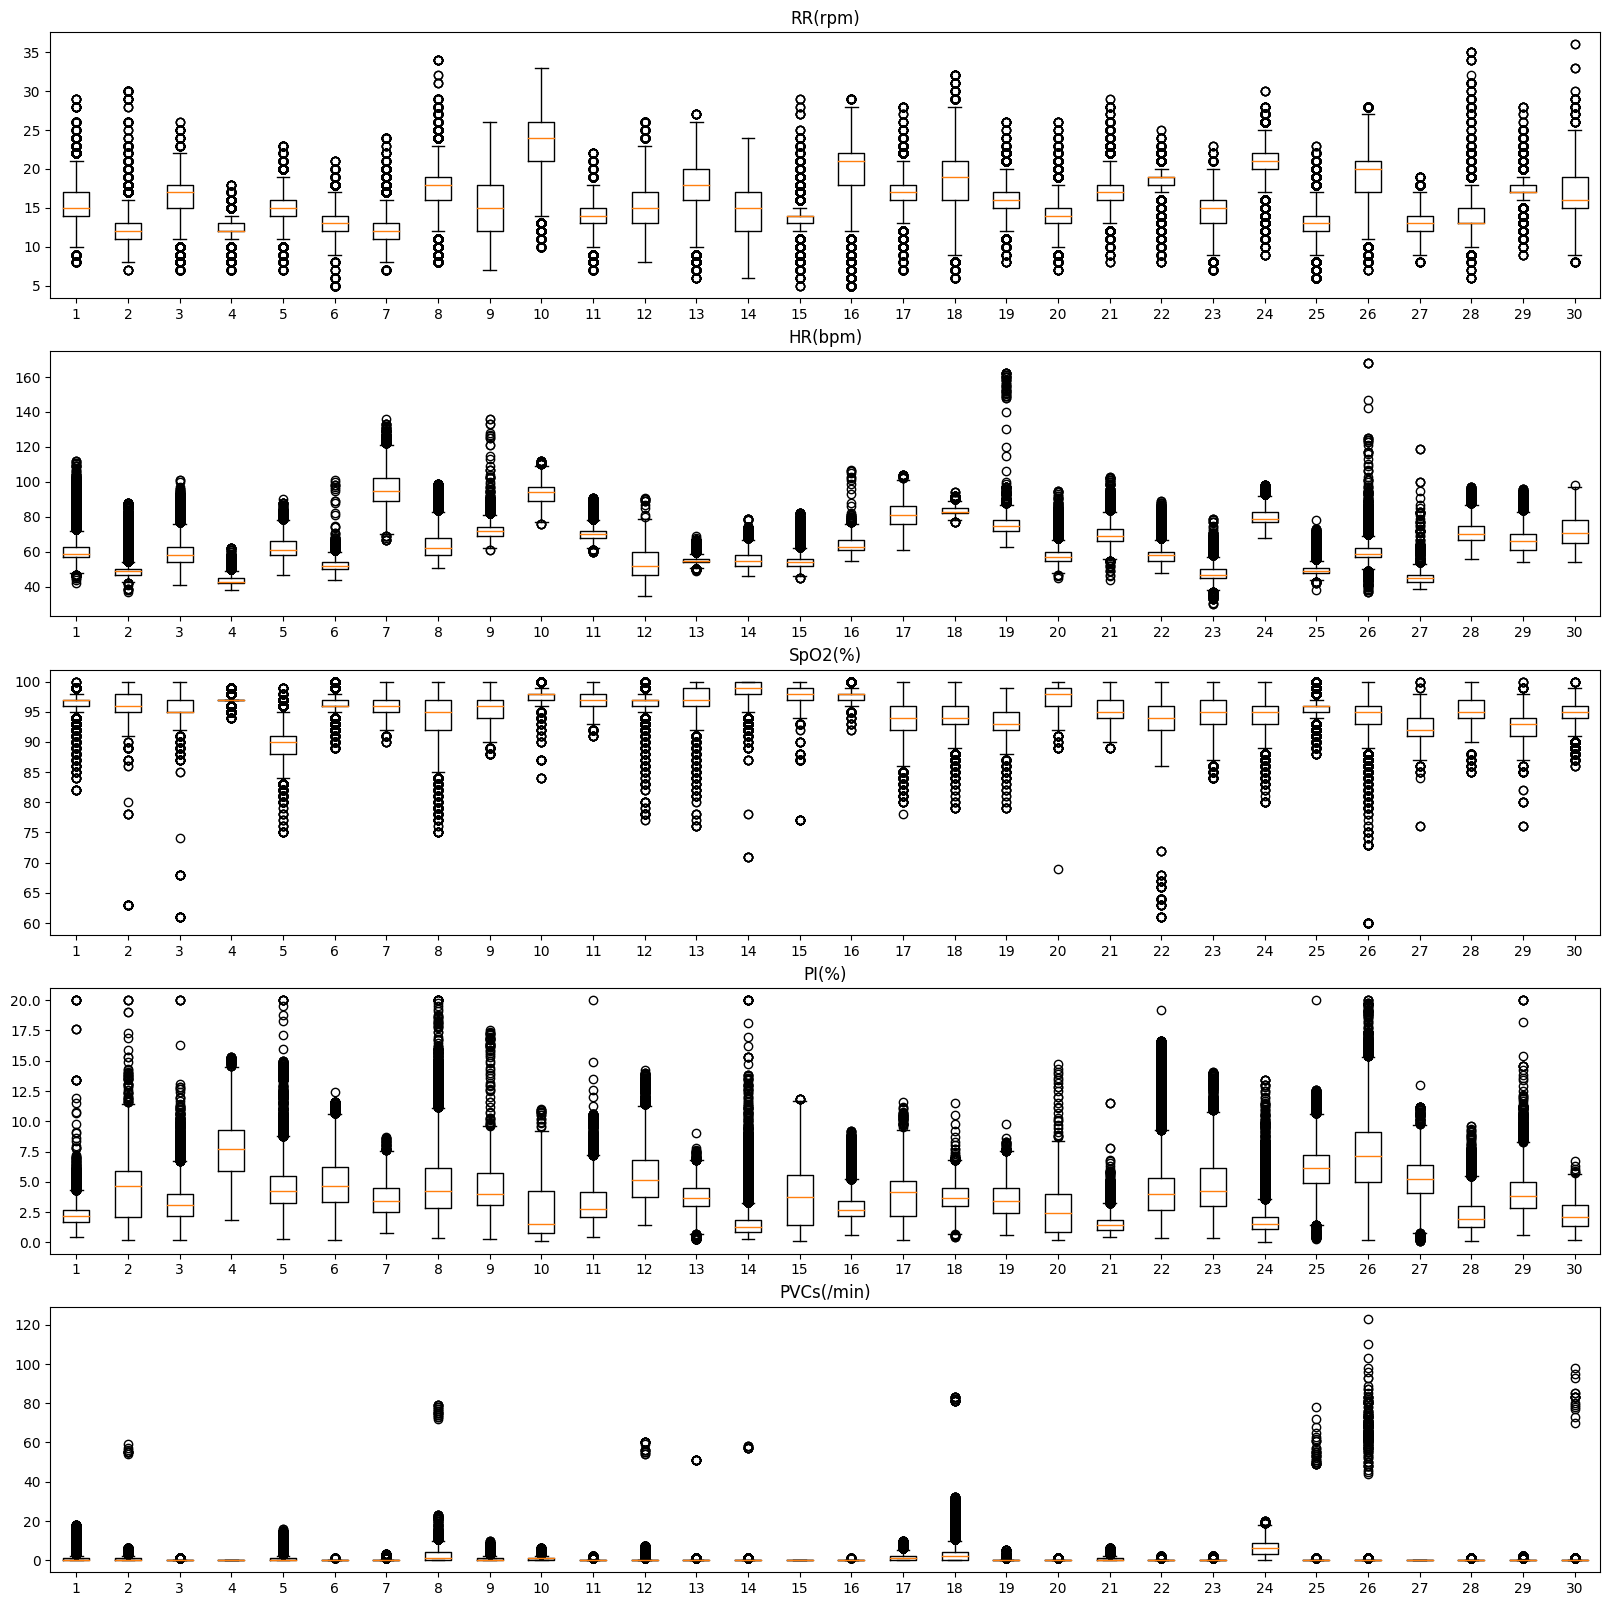

In [3]:
features = ['RR(rpm)', 'HR(bpm)', 'SpO2(%)', 'PI(%)', 'PVCs(/min)']

fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the each patient, do a box plot
for index in range(len(features)):
    ax[index].set_title(features[index])
    
    patient_data = []
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][features[index]]
        patient_data.append([x for x in list(temp.values) if not np.isnan(x)] )
    
    ax[index].boxplot(patient_data)

plt.show()

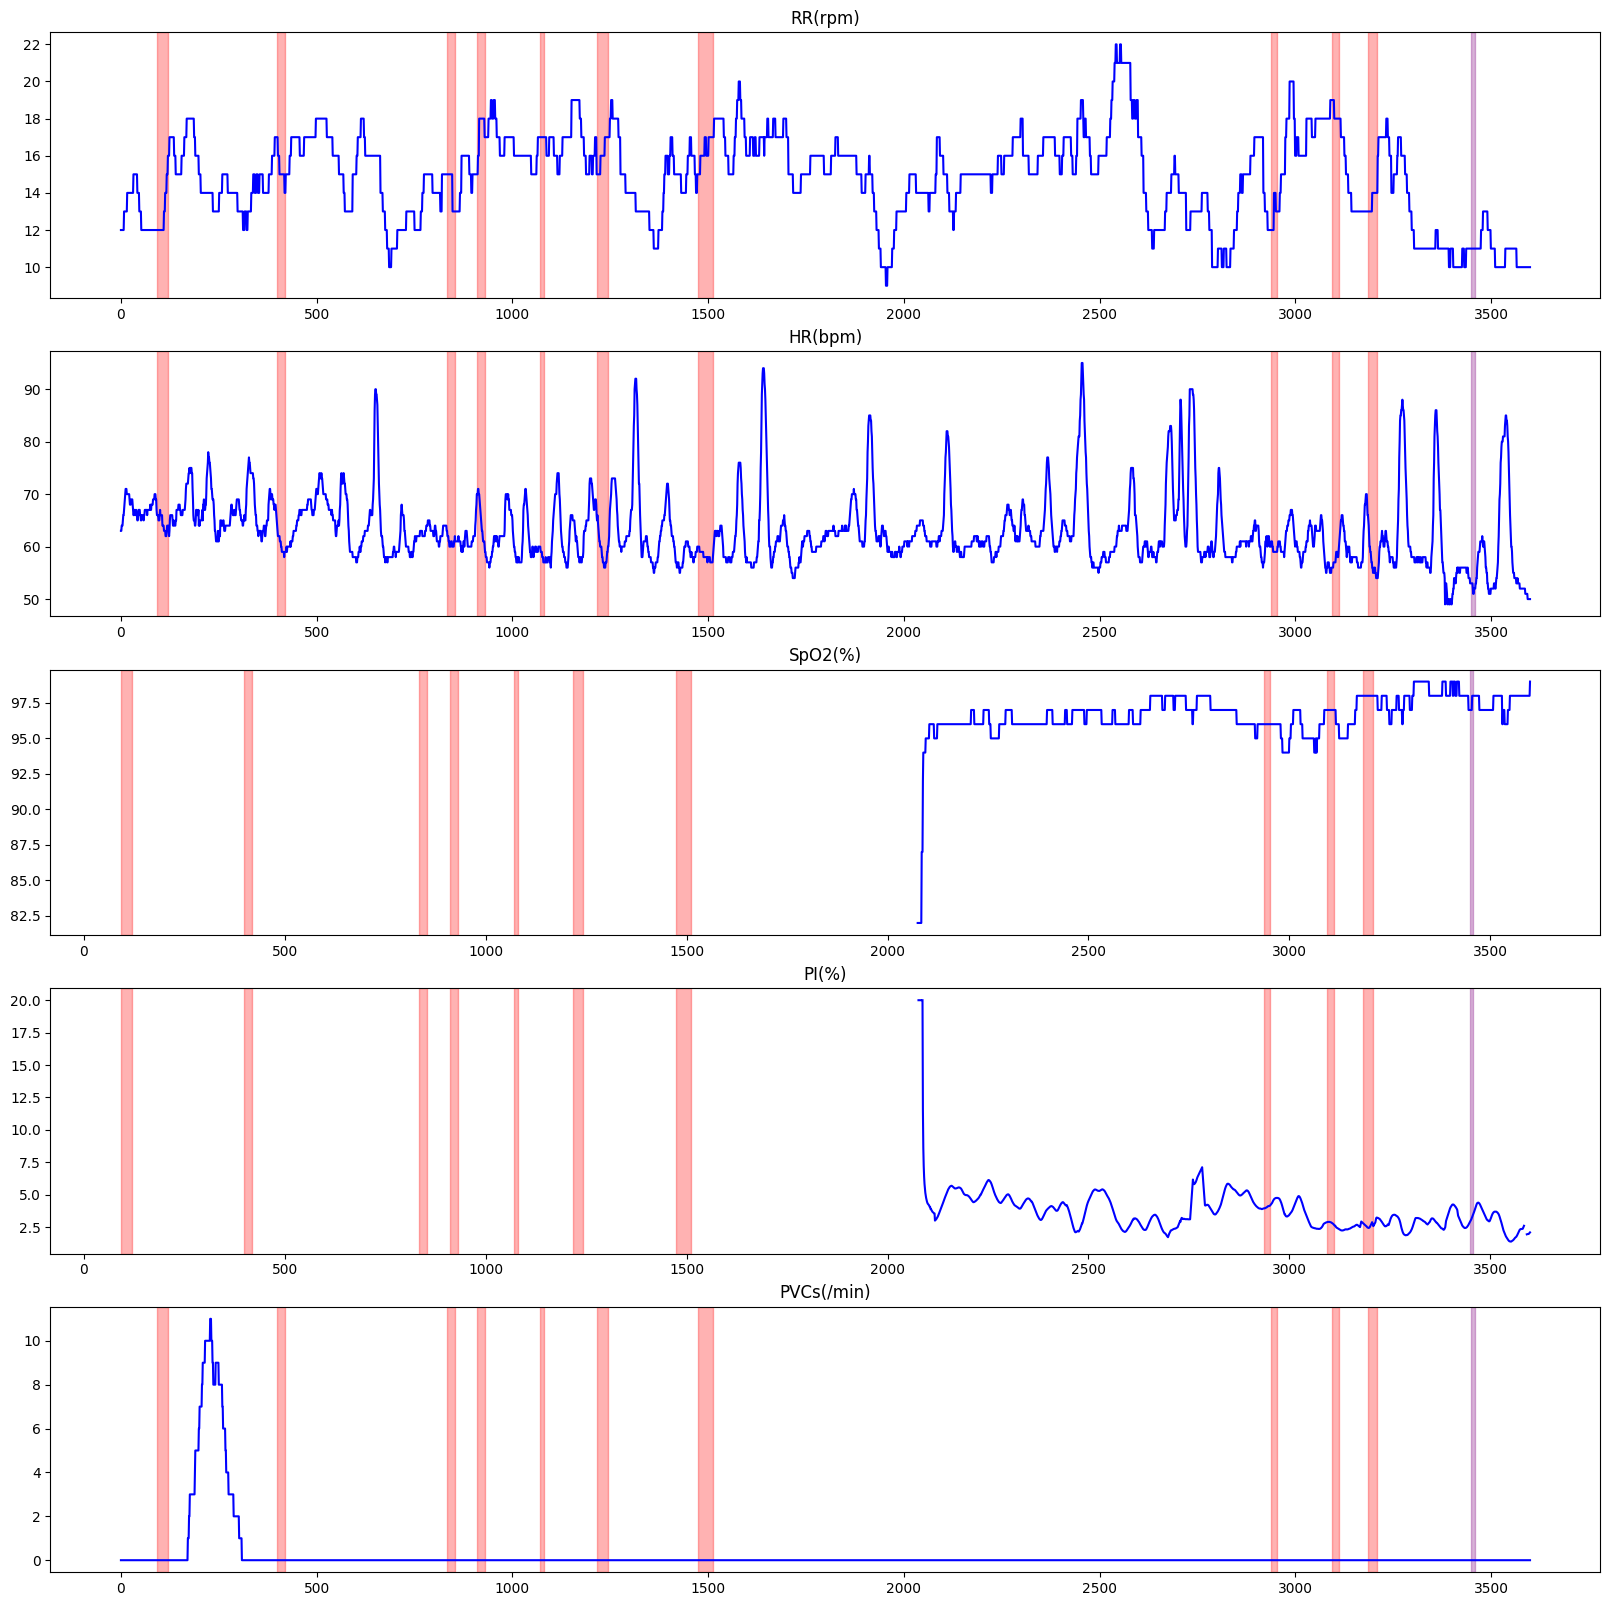

In [4]:
## Plot an hour of data for each of the features
## If you notice, the plots for SpO2 and PI% don't begin until around 2100 for patient 1
## The values for the first portions of the data are NaNs so the data is missing
## The fact that there is missing data can be seen more clearly in the bottom table where there is
##   approximately 8% data missing for both of these features.
## I believe that these two measurements are often collected via the same device so it is likely that
##   the NaNs are place values for the time prior to hooking up the device.
## In addition, the red markings on the time series plot indicates hypopnea events marked by a clinician
##   while the purple marking indicates an apnea event. Idealy we would be able to see some correlation.

## Takes a set of patient data (assumes only a single patient) and a start and end then returns
##    a list of start and ending tuples. You can also specify the types it expects a list of
##    the valid types such as ['APNEA-CENTRAL' 'APNEA-MIXED' 'APNEA-OBSTRUCTIVE' 'HYPOPNEA' 'NONE']
def get_list_of_events(df, start, end, event_type):
    
    ## Will be in the format of [ (start1, end1), (start2, end2)] ]
    event_list = []
    
    current_start = 0
    
    ## State identifier if we are inside of an event range or out of it
    in_event = 0
    
    for i in range(start, end + 1):
        ## We are in an event if it is both the correct type and we have encountered a 1
        if df['anomaly'][i] == 1 and in_event == 0 and df['event'][i] in event_type:
            in_event = 1
            current_start = i
        elif df['anomaly'][i] == 1 and in_event == 1 and df['event'][i] not in event_type:
            ## If we are in an event and the type switches we have to stop
            in_event = 0
            event_list.append( (current_start, i - 1) )
        elif df['anomaly'][i] == 0 and in_event == 1:
            in_event = 0
            event_list.append( (current_start, i - 1) )
    
    return event_list
        
fig, ax = plt.subplots(nrows=len(features), ncols=1, figsize=(20,20))

## For each feature for the first patient, graph a time series over the first hour of monitoring
for index in range(len(features)):
    ax[index].set_title(features[index])
    
    ## Only take the first hour of data
    plot_data = data[data['patient'] == '1'][features[index]].head(3600)
    
    ax[index].plot(list(range(0,3600)), plot_data, color='b')
    
    apnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['APNEA-CENTRAL','APNEA-MIXED','APNEA-OBSTRUCTIVE'])
    hypopnea_events = get_list_of_events(data[data['patient'] == '1'], 0, 3600, ['HYPOPNEA'])
    
    for start, end in apnea_events:
        ax[index].axvspan(start, end, color="purple", alpha=0.3)
        
    for start, end in hypopnea_events:
        ax[index].axvspan(start, end, color="red", alpha=0.3)
    
plt.show()

In [5]:
## Calculate missing data %

## Some of these patients have significant chunks of missing data primarily in regards to SpO2 and PI%
##  Given how much is missing we may not be able to depend too heavily on these features for training our model.

patient_missing = {}

for feat in features:

    patient_missing[feat] = []
    
    for patient_id in np.unique(data['patient']):
        temp = data[data['patient'] == patient_id][feat]
        vals = list(temp.values)
        missing = len([x for x in vals if np.isnan(x)] ) / len(vals)
        patient_missing[feat].append(missing)

df = pd.DataFrame(patient_missing, index = np.unique(data['patient']))
display(df)

,RR(rpm),HR(bpm),SpO2(%),PI(%),PVCs(/min)
1,0.000040,0.000040,0.083287,0.084598,0.000040
10,0.058771,0.058454,0.177870,0.178991,0.058454
11,0.000033,0.000033,0.220888,0.222500,0.000033
12,0.015027,0.000033,0.000066,0.000066,0.000033
13,0.001645,0.000059,0.019127,0.020302,0.000059
14,0.001219,0.000027,0.025975,0.026842,0.000027
15,0.006132,0.001933,0.190545,0.190606,0.001933
16,0.044314,0.000464,0.119314,0.120674,0.000464
17,0.002415,0.000034,0.657295,0.657640,0.000034
18,0.000028,0.000028,0.373101,0.373686,0.000028
